We need your help with two things. They're focused around the market making part of our model, so run the code blocks below and the instructions will be towards the end.

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [ ]:
# Load data (takes like 9 seconds to run don't panic)

data = pd.read_excel('https://s3.amazonaws.com/stockx-sneaker-analysis/wp-content/uploads/2019/02/StockX-Data-Contest-2019.xlsx', sheet_name = 1)
df = data.copy()
df

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island
...,...,...,...,...,...,...,...,...
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565.0,220,2018-12-26,8.0,Oregon
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598.0,220,2018-12-26,8.5,California
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605.0,220,2018-12-26,5.5,New York
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650.0,220,2018-12-26,11.0,California


In [ ]:
# calculating volatility through standard deviations

def calculate_moving_volatility(data, window=5):
    # create a copy that we can sort
    sorted_data = data.copy()

    # find the standard deviation of the shoe. We want each calculation to be shoe and size specific.
    volatility = sorted_data.groupby(['Sneaker Name', 'Shoe Size'])['Sale Price'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # for shoes where window size > number of shoes, impute with standard deviation of that shoe and size even though it's smaller.
    volatility = volatility.fillna(sorted_data.groupby(['Sneaker Name', 'Shoe Size'])['Sale Price'].transform('std'))

    # in case there's any values that still didn't get calculated, just use the standard deviation of that shoe.
    volatility = volatility.fillna(sorted_data['Sale Price'].std())

    # add it as a column
    sorted_data['Volatility'] = volatility

    return sorted_data

df = calculate_moving_volatility(df, window=5)
df

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Volatility
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California,131.051213
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California,53.403109
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California,52.491764
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky,81.829662
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island,39.646538
...,...,...,...,...,...,...,...,...,...
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565.0,220,2018-12-26,8.0,Oregon,18.047160
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598.0,220,2018-12-26,8.5,California,19.295077
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605.0,220,2018-12-26,5.5,New York,8.700575
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650.0,220,2018-12-26,11.0,California,22.029526


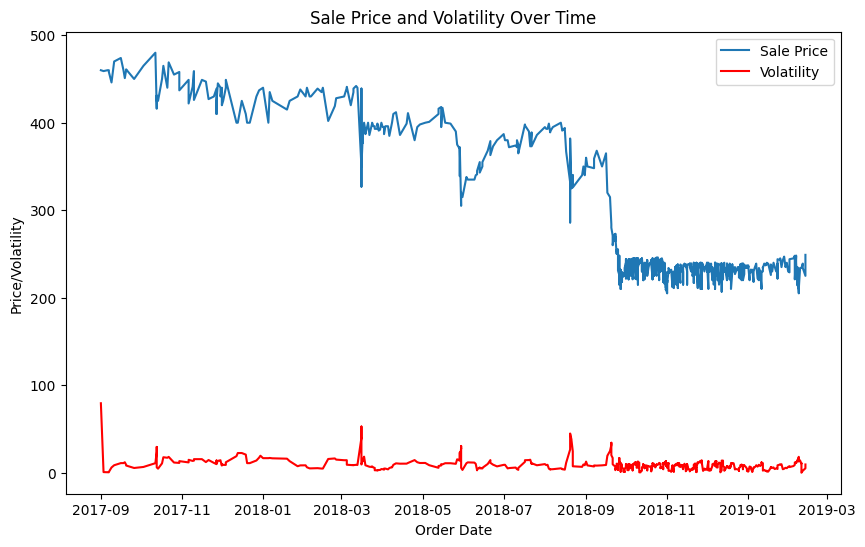

In [ ]:
# this code will plot the volatility and price so we can see how they're related

# pick your specific shoe name and size that you want to generate this plot for
sample_data = df[(df['Sneaker Name'] == 'Adidas-Yeezy-Boost-350-V2-Cream-White') &
                                 (df['Shoe Size'] == 9)]

# a la chat gpt
plt.figure(figsize=(10, 6))
plt.plot(sample_data['Order Date'], sample_data['Sale Price'], label='Sale Price')
plt.plot(sample_data['Order Date'], sample_data['Volatility'], label='Volatility', color='red')
plt.title('Sale Price and Volatility Over Time')
plt.xlabel('Order Date')
plt.ylabel('Price/Volatility')
plt.legend()
plt.show()

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])

df['Order Date'] = df['Order Date'].apply(lambda x: x.toordinal())
df['Release Date'] = df['Release Date'].apply(lambda x: x.toordinal())

df['Delta'] = (df['Sale Price'] - df['Retail Price'])/df['Retail Price']
df

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Volatility,Delta
0,736573,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,736231,11.0,California,131.051213,3.986364
1,736573,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,736291,11.0,California,53.403109,2.113636
2,736573,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,736291,11.0,California,52.491764,2.136364
3,736573,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,736291,11.5,Kentucky,81.829662,3.886364
4,736573,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,736371,11.0,Rhode Island,39.646538,2.763636
...,...,...,...,...,...,...,...,...,...,...
99951,737103,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565.0,220,737054,8.0,Oregon,18.047160,1.568182
99952,737103,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598.0,220,737054,8.5,California,19.295077,1.718182
99953,737103,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605.0,220,737054,5.5,New York,8.700575,1.750000
99954,737103,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650.0,220,737054,11.0,California,22.029526,1.954545


In [ ]:
Y = df['Sale Price']
vol = df['Volatility']
df = df.drop(['Sale Price', 'Retail Price', 'Delta', 'Volatility'], axis=1)
X = pd.get_dummies(df)
X

,Order Date,Release Date,Shoe Size,Brand_ Yeezy,Brand_Off-White,Sneaker Name_Adidas-Yeezy-Boost-350-Low-Moonrock,Sneaker Name_Adidas-Yeezy-Boost-350-Low-Oxford-Tan,Sneaker Name_Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015,Sneaker Name_Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016,Sneaker Name_Adidas-Yeezy-Boost-350-Low-Turtledove,...,Buyer Region_South Dakota,Buyer Region_Tennessee,Buyer Region_Texas,Buyer Region_Utah,Buyer Region_Vermont,Buyer Region_Virginia,Buyer Region_Washington,Buyer Region_West Virginia,Buyer Region_Wisconsin,Buyer Region_Wyoming
0,736573,736231,11.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,736573,736291,11.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,736573,736291,11.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,736573,736291,11.5,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,736573,736371,11.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,737103,737054,8.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99952,737103,737054,8.5,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99953,737103,737054,5.5,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99954,737103,737054,11.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# models we'll use
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100),
}

# for each model, we want to train it, predict, then grade it
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {'MSE': mse, 'R^2': r2}



# results
results_df = pd.DataFrame(results).T
results_df['MSE'] = results_df['MSE']
results_df['R^2'] = results_df['R^2']

print(results_df)

                       MSE       R^2
Random Forest  1072.661089  0.983152


In [ ]:
# now we just want to focus on market making so we're going to get rid of a bunch of data in our dataset
df['Sales Price'] = Y
df['Predicted Price'] = model.predict(X)
df = df.drop(['Release Date', 'Buyer Region', 'Brand'], axis=1)
df

,Order Date,Sneaker Name,Shoe Size,Sales Price,Predicted Price
0,736573,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1097.0,1084.900000
1,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,11.0,685.0,691.780000
2,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,11.0,690.0,668.690000
3,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,11.5,1075.0,1059.910000
4,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,11.0,828.0,822.183333
...,...,...,...,...,...
99951,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,8.0,565.0,580.150000
99952,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,8.5,598.0,605.614155
99953,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,5.5,605.0,610.454155
99954,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,11.0,650.0,680.974282


Here's where we need your help. Right now, the way we market make is we take a specific shoe model (every shoe that has the same name and size like a kobe grinch 6 size 11), and look at it's average price over the past x days (you can adjust what x is, it's the window size in the calculate_moving_volatility above), and then use that to find the standard deviation for that model.

Basically, our idea is that our spread should be related to volatility, and standard deviation is a good way to calculate volatility. If you have a realllly big standard deviation, that means prices can vary a lot, so high volatility and vice versa. So, our formula for now is $Spread = k * \sigma$. We already claculated the standard deviation, so we have $\sigma$. The first thing we need help with is finding a good value of k.

We don't want k to just be some constant otherwise we'll have an unoptimal spread. For example, if you sold 100 pairs of one shoe with a low $\sigma$, and 2 pairs of another with a high $\sigma$, then you'd want different k values for both of them, so you can make a loooot more money on the volatile second type and minimize risk and be conservative on the first type.

We don't have time to make k really elaborate. What we were thinking is that if we had time, we could set $k = a_1 x_1 + a_2 x_2 + \dots a_n x_n$, where each variable x is some market condition and each $a_i$ is some weight that affects how much of it we want to capture. For example, the code Emma wrote for sentiment analysis could be one of these variables and we could find a weight in calculating k. But, we don't have that much time, so we're just going to make k dependent on volume.

So, to be more clear, your first task is to find some good values for this line:
df['k'] = df['Count'].apply(lambda count: 0.5 if count <= 5 else 0.3)
that leads to good looking spreads. Like change 0.5, 0.3, and 5 to different values. We don't have anything to test what makes a spread good, so just use your best judgment, and be able to explain why you prefer one spread over another. E.g. we don't want a spread with [800,1200] otherwise no one is gonna buy from us or sell to us, just reasoning like that.

The second task is to use matplotlib or some other library to plot the bid,ask, and predicted price for a shoe and a specific size, so we can visualize what our spreads actually look like.

In [ ]:
# this block of code is where we actually market make

df['Volatility'] = vol # adding back volatility as a column

# keeping track of how many times a specific shoe and its size appears
shoe_counts = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index(name='Count')

# addind that information to the dataframe, dropping some stuff because it's kind of janky
df = df.merge(shoe_counts, on=['Sneaker Name', 'Shoe Size'], suffixes=('', '_count'))
# df = df.drop(['Count_x', 'Count_y, Count_count'], axis = 1)

# coefficient of volatility- Play around with this and see if you can find one that gives us a good looking spread.
df['k'] = df['Count'].apply(lambda count: 0.2 if count >= 20 else (0.35 if count >= 6 else 0.5))

# calculate spread
df['Spread'] = df['k'] * df['Volatility']

# calculate bid and ask prices from spread and display dataframe
df['Bid'] = df['Predicted Price'] + df['Spread'] / 2
df['Ask'] = df['Predicted Price'] - df['Spread'] / 2
df

,Order Date,Sneaker Name,Shoe Size,Sales Price,Predicted Price,Volatility,Count,Count_count,Count_count,Count_count,k,Spread,Bid,Ask
0,736573,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1097.0,1084.900000,131.051213,40,40,40,40,0.20,26.210243,1098.005121,1071.794879
1,736583,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1050.0,1064.020000,53.403109,40,40,40,40,0.20,10.680622,1069.360311,1058.679689
2,736595,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1060.0,1079.050000,52.491764,40,40,40,40,0.20,10.498353,1084.299176,1073.800824
3,736603,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1150.0,1104.860000,81.829662,40,40,40,40,0.20,16.365932,1113.042966,1096.677034
4,736609,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,999.0,1031.360000,39.646538,40,40,40,40,0.20,7.929308,1035.324654,1027.395346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,737101,Nike-Air-Max-90-Off-White-Black,14.0,570.0,554.735000,18.047160,6,6,6,6,0.35,6.316506,557.893253,551.576747
99952,737102,Nike-Air-Max-90-Off-White-Black,14.0,525.0,519.571479,19.295077,6,6,6,6,0.35,6.753277,522.948117,516.194841
99953,737096,Nike-Air-Max-90-Off-White-Desert-Ore,15.0,765.0,713.830000,8.700575,3,3,3,3,0.50,4.350287,716.005144,711.654856
99954,737099,Nike-Air-Max-90-Off-White-Desert-Ore,15.0,674.0,670.410000,22.029526,3,3,3,3,0.50,11.014763,675.917381,664.902619


In [ ]:
# NOTE: this code just uses a constant for k instead of changing it. Don't run this code if you're going to run the one above. It can be helpful for seeing how k affects the spread.
df['Volatility'] = vol

k = 0.5

# calculate spread
df['Spread'] = k * df['Volatility']

# calculate bid and ask prices from spread and display dataframe
df['Bid'] = df['Predicted Price'] + df['Spread'] / 2
df['Ask'] = df['Predicted Price'] - df['Spread'] / 2
df

,Order Date,Sneaker Name,Shoe Size,Sales Price,Predicted Price,Volatility,Spread,Bid,Ask
0,736573,Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1097.0,1085.190000,131.051213,65.525607,1117.952803,1052.427197
1,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,11.0,685.0,695.260000,53.403109,26.701554,708.610777,681.909223
2,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,11.0,690.0,670.830000,52.491764,26.245882,683.952941,657.707059
3,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,11.5,1075.0,1058.610000,81.829662,40.914831,1079.067415,1038.152585
4,736573,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,11.0,828.0,818.068333,39.646538,19.823269,827.979968,808.156699
...,...,...,...,...,...,...,...,...,...
99951,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,8.0,565.0,576.669662,18.047160,9.023580,581.181452,572.157872
99952,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,8.5,598.0,612.080000,19.295077,9.647539,616.903769,607.256231
99953,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,5.5,605.0,614.534493,8.700575,4.350287,616.709637,612.359349
99954,737103,adidas-Yeezy-Boost-350-V2-Static-Reflective,11.0,650.0,681.685036,22.029526,11.014763,687.192417,676.177654


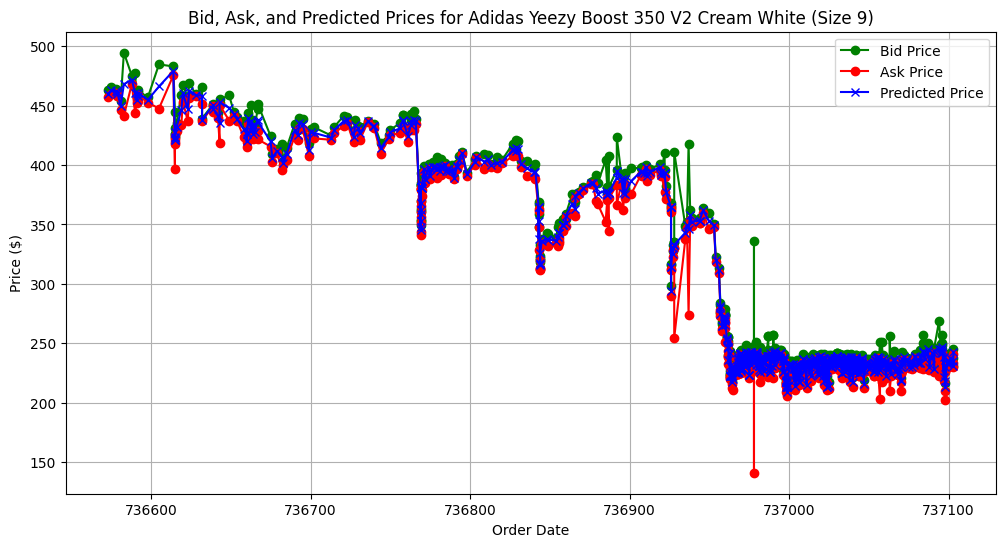

In [ ]:
import matplotlib.pyplot as plt

# Filter for a specific shoe and size
specific_shoe = df[(df['Sneaker Name'] == 'Adidas-Yeezy-Boost-350-V2-Cream-White') & (df['Shoe Size'] == 9.0)]

# Sorting data by date if not already sorted
specific_shoe = specific_shoe.sort_values('Order Date')
specific_shoe = specific_shoe[(specific_shoe['Order Date'] >= 736600) & (specific_shoe['Order Date'] <= 736700)]

# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(specific_shoe['Order Date'], specific_shoe['Bid'], label='Bid Price', color='green', marker='o')
plt.plot(specific_shoe['Order Date'], specific_shoe['Ask'], label='Ask Price', color='red', marker='o')
plt.plot(specific_shoe['Order Date'], specific_shoe['Predicted Price'], label='Predicted Price', color='blue', marker='x')

plt.title('Bid, Ask, and Predicted Prices for Adidas Yeezy Boost 350 V2 Cream White (Size 9)')
plt.xlabel('Order Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()